In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc

from shared.utils import *
from shared.kaggle_path import *

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

strategy = tf.distribute.MirroredStrategy()

# Data Preprocessing
## Audio Data

In [5]:
label = []
filepath = []

for classes in os.listdir(AUDIO_PATH):
    for file in os.listdir(os.path.join(AUDIO_PATH, classes)):
        file_path = os.path.join(AUDIO_PATH, classes, file)

        filepath.append(file_path)
        label.append(classes)

audio = pd.DataFrame({
    'filepath': filepath,
    'label': label,
})

del filepath, label

audio.head()

,filepath,label
0,/kaggle/working/dataset/audio/disgust/1065_TIE...,disgust
1,/kaggle/working/dataset/audio/disgust/1036_TIE...,disgust
2,/kaggle/working/dataset/audio/disgust/1004_ITH...,disgust
3,/kaggle/working/dataset/audio/disgust/1016_IEO...,disgust
4,/kaggle/working/dataset/audio/disgust/1063_MTI...,disgust


In [6]:
le = LabelEncoder()
le.fit(audio['label'])
audio['label_encoded'] = le.transform(audio['label'])
num_classes = len(le.classes_)

In [7]:
# with tf.device('/GPU:0'):
with strategy.scope():
    audio['data'] = audio.filepath.apply(preprocess_audio)
    audio = audio.sample(frac=1).reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=96
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1152
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1056
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=320
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1280
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1792
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:26

In [8]:
x_audio = np.stack(audio['data'].values)
y_audio = audio['label_encoded'].values
print(x_audio.shape)
del audio

(27406, 128, 110, 3)


In [9]:
x_audio_train, x_temp, y_audio_train, y_temp = train_test_split(
    x_audio, y_audio, test_size=0.3, random_state=100,
)

x_audio_val, x_audio_test, y_audio_val, y_audio_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=222, shuffle=True, stratify=y_temp
)

del x_audio, y_audio
print(x_audio_train.shape)
print(x_audio_train.shape[0] == len(y_audio_train))

(19184, 128, 110, 3)
True


# Modeling
## Model Image

In [10]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(128, 110, 3)),
)

base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


In [11]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

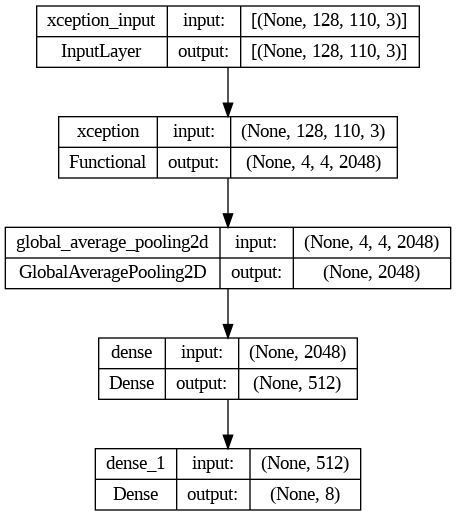

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.2,
                                                    min_lr=1e-6,
                                                    patience=3,
                                                    mode='min'
                                                    )

In [14]:
history = model.fit(
    x_audio_train,
    y_audio_train,
    validation_data=(x_audio_val, y_audio_val),
    # callbacks=[early, checkpoint, lr_scheduler],
    epochs=100,
    verbose=2,
    batch_size=64,
    steps_per_epoch=len(x_audio_train) // 64,
    validation_steps=len(x_audio_val) // 64,
)


Epoch 1/100


I0000 00:00:1746867107.155029     147 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


299/299 - 48s - loss: 1.6336 - accuracy: 0.3906 - val_loss: 1.4219 - val_accuracy: 0.4587 - 48s/epoch - 159ms/step
Epoch 2/100
299/299 - 33s - loss: 1.3537 - accuracy: 0.4845 - val_loss: 1.3491 - val_accuracy: 0.4971 - 33s/epoch - 111ms/step
Epoch 3/100
299/299 - 33s - loss: 1.2599 - accuracy: 0.5174 - val_loss: 1.2698 - val_accuracy: 0.5188 - 33s/epoch - 110ms/step
Epoch 4/100
299/299 - 33s - loss: 1.1952 - accuracy: 0.5452 - val_loss: 1.2549 - val_accuracy: 0.5325 - 33s/epoch - 109ms/step
Epoch 5/100
299/299 - 32s - loss: 1.1372 - accuracy: 0.5703 - val_loss: 1.2504 - val_accuracy: 0.5254 - 32s/epoch - 108ms/step
Epoch 6/100
299/299 - 33s - loss: 1.0993 - accuracy: 0.5835 - val_loss: 1.2256 - val_accuracy: 0.5361 - 33s/epoch - 109ms/step
Epoch 7/100
299/299 - 33s - loss: 1.0581 - accuracy: 0.6027 - val_loss: 1.1972 - val_accuracy: 0.5493 - 33s/epoch - 109ms/step
Epoch 8/100
299/299 - 33s - loss: 1.0203 - accuracy: 0.6203 - val_loss: 1.1853 - val_accuracy: 0.5527 - 33s/epoch - 109ms/s

In [15]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [16]:
plot_and_save('loss', history, 'Loss', 'audio_loss_plot.png')
plot_and_save('accuracy', history, 'Audio Classification Accuracy', 'audio_class_accuracy_plot.png')

In [17]:
predictions = model.predict(x_audio_test)
predictions = np.argmax(predictions, axis=1)

129/129 [==============================] - 9s 50ms/step


In [18]:
classes = [x for x in os.listdir(TRAIN_IMAGE_PATH)]
print(classes)

['disgust', 'surprise', 'neutral', 'sad', 'fear', 'angry', 'happy']


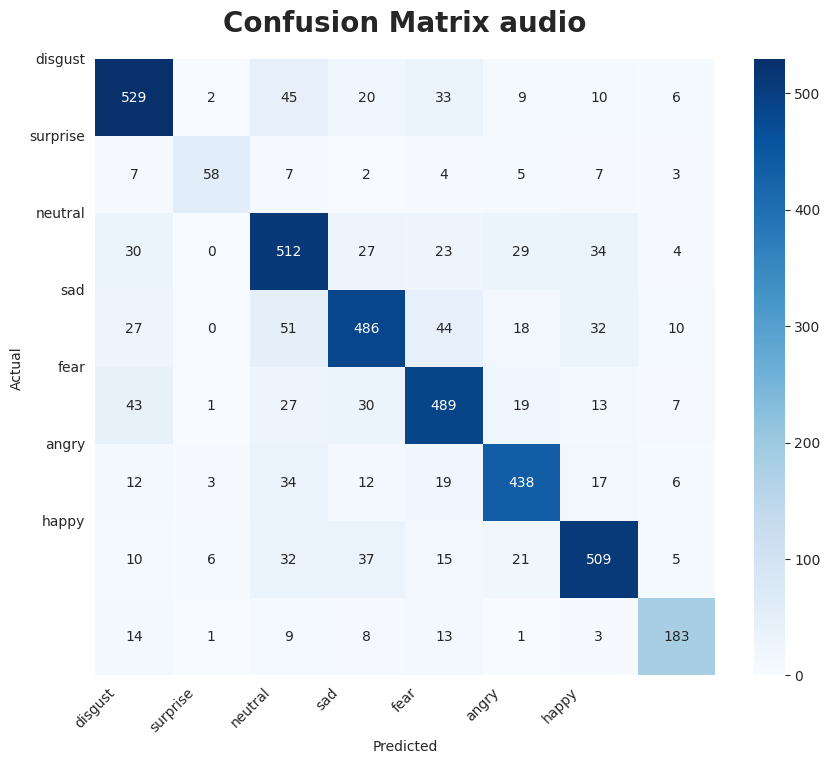

In [19]:
cm = confusion_matrix(y_audio_test, predictions)

plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix audio', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Set ticks for the x and y axes using class names
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
print(classification_report(y_audio_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       654
           1       0.82      0.62      0.71        93
           2       0.71      0.78      0.74       659
           3       0.78      0.73      0.75       668
           4       0.76      0.78      0.77       629
           5       0.81      0.81      0.81       541
           6       0.81      0.80      0.81       635
           7       0.82      0.79      0.80       232

    accuracy                           0.78      4111
   macro avg       0.79      0.76      0.77      4111
weighted avg       0.78      0.78      0.78      4111

